In [126]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, pathpatch_2d_to_3d
import scipy.spatial as ss

from dosipy.utils.dataloader import load_antenna_el_properties
from dosipy.utils.viz import set_axes_equal, fig_config, set_colorblind


set_colorblind()
%config InlineBackend.figure_format = 'retina'

# utils

In [142]:
def sph2cart(r, theta, phi):
    x = r * np.cos(phi) * np.sin(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(theta)
    return x, y, z


def cart2sph(x, y, z):
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    return r, theta, phi

# input data

In [138]:
# frequency
f = 5e9

# separation distance
h = -2.5 / 1000

# averaging surface
if f < 30e9:
    target_area = (0.02, 0.02)
else:
    target_area = (0.01, 0.01)
A = target_area[0] * target_area[1]
target_area_origin = (-target_area[0]/2, -target_area[1]/2)

# source
data = load_antenna_el_properties(f)
xs = data.x.to_numpy()
xs -= xs.max() / 2
ys = np.zeros_like(xs) + h
zs = np.zeros_like(xs)
Is = np.abs(data.ireal.to_numpy() + 1j * data.iimag.to_numpy())

# planar target - reference

In [143]:
N = 8
x = np.linspace(-target_area[0]/2, target_area[0]/2, N)
y = 0.0
z = np.linspace(-target_area[1]/2, target_area[1]/2, N)
Xt, Zt = np.meshgrid(x, z)
xt_pln = Xt.ravel()
yt_pln = np.zeros_like(xt_pln)
zt_pln = Zt.ravel()

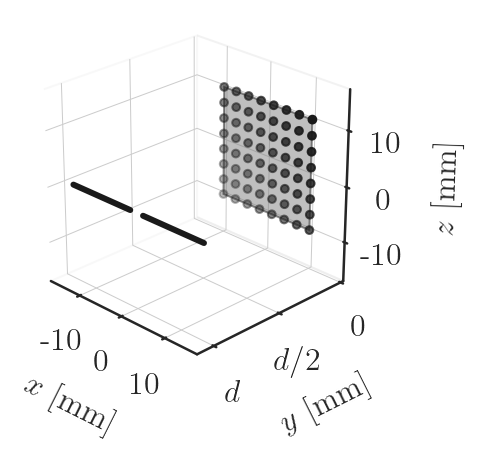

In [166]:
fig_config(latex=True, scaler=1)
fig = plt.figure()
ax = plt.axes(projection ='3d')
plane = Rectangle(target_area_origin, target_area[0], target_area[1], ec='k', ls='-', fc='gray', alpha=0.5)
ax.add_patch(plane)
pathpatch_2d_to_3d(plane, z=y, zdir='y')
ax.scatter(xt_pln, yt_pln, zt_pln, s=15, color='k', depthshade=True)
ax.plot(xs[:24], ys[:24], zs[:24], 'k-')
ax.plot(xs[28:], ys[28:], zs[28:], 'k-')
ax.set_box_aspect([1, 1, 1])
ax.set(xlabel='$x$ [mm]', ylabel='$y$ [mm]', zlabel='$z$ [mm]',
       xticks=[xt_pln.min(), 0.0, xt_pln.max()],
       yticks=[h, h/2, 0.0],
       zticks=[zt_pln.min(), 0.0, zt_pln.max()],
       xticklabels=[int(xt_pln.min()*1000), 0, int(xt_pln.max()*1000)],
       yticklabels=['$d$', '$d/2$', 0],
       zticklabels=[int(zt_pln.min()*1000), 0, int(zt_pln.max()*1000)],
       xlim=[xs.min()*1.1, xs.max()*1.1],
       ylim=[h*1.1, 0.0],
       zlim=[xs.min()*1.1, xs.max()*1.1],
      )
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.zaxis.labelpad = 10
ax.view_init(25, -45)
fig.tight_layout()

# spherical target - model

In [167]:
theta = np.linspace(0, 2 * np.pi, 41)
phi = np.linspace(0, np.pi, 21)
Theta, Phi = np.meshgrid(theta, phi)

# model of an average adult
r_adult = 0.076
xt_adult, yt_adult, zt_adult = sph2cart(r_adult, Theta.ravel(), Phi.ravel())
xyz_adult = np.c_[xt_adult, yt_adult, zt_adult]
hull_adult = ss.ConvexHull(xyz_adult)

# model of an average child
r_child = 0.057
xt_child, yt_child, zt_child = sph2cart(r_child, Theta.ravel(), Phi.ravel())
xyz_child = np.c_[xt_child, yt_child, zt_child]
hull_child = ss.ConvexHull(xyz_child)

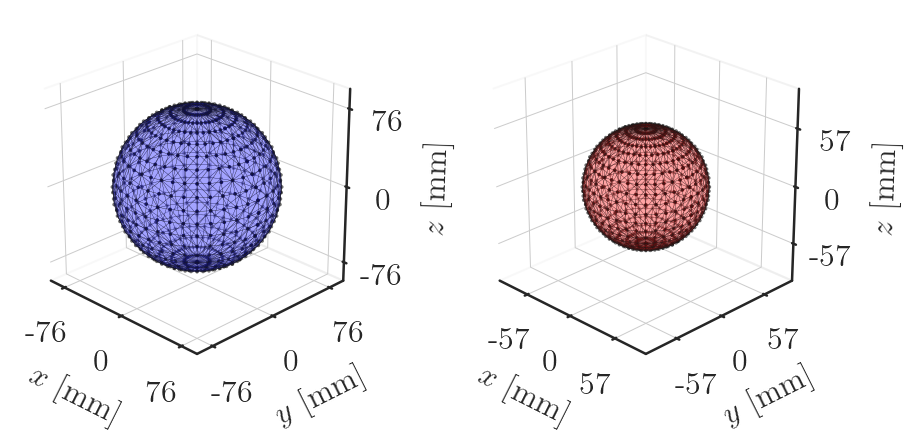

In [171]:
fig_config(latex=True, ncols=2)
fig = plt.figure(figsize=plt.figaspect(0.45))

# adult
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(xt_adult, yt_adult, zt_adult, s=3, marker='.', ec='k', c='None')
hull_triangle_coords = hull_adult.points[hull_adult.simplices]
triangles = Poly3DCollection(hull_triangle_coords, color='blue', ec='k', lw=0.1, alpha=0.2)
ax.add_collection3d(triangles)
ax.set_box_aspect([1, 1, 1])
ax = set_axes_equal(ax)
ax.set(xlabel='$x$ [mm]', ylabel='$y$ [mm]', zlabel='$z$ [mm]',
       xticks=[-r_adult, 0, r_adult],
       yticks=[-r_adult, 0, r_adult],
       zticks=[-r_adult, 0, r_adult],
       xticklabels=[-int(r_adult * 1000), 0, int(r_adult * 1000)],
       yticklabels=[-int(r_adult * 1000), 0, int(r_adult * 1000)],
       zticklabels=[-int(r_adult * 1000), 0, int(r_adult * 1000)],
       xlim=[-r_adult * 1.2, r_adult * 1.2],
       ylim=[-r_adult * 1.2, r_adult * 1.2],
       zlim=[-r_adult * 1.2, r_adult * 1.2],
      )
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.labelpad = 7
ax.yaxis.labelpad = 7
ax.zaxis.labelpad = 7
ax.view_init(25, -45)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(xt_child, yt_child, zt_child, s=3, marker='.', ec='k', c='None')
hull_triangle_coords = hull_child.points[hull_adult.simplices]
triangles = Poly3DCollection(hull_triangle_coords, color='red', ec='k', lw=0.1, alpha=0.2)
ax.add_collection3d(triangles)
ax.set_box_aspect([1, 1, 1])
ax = set_axes_equal(ax)
ax.set(xlabel='$x$ [mm]', ylabel='$y$ [mm]', zlabel='$z$ [mm]',
       xticks=[-r_child, 0, r_child],
       yticks=[-r_child, 0, r_child],
       zticks=[-r_child, 0, r_child],
       xticklabels=[-int(r_child * 1000), 0, int(r_child * 1000)],
       yticklabels=[-int(r_child * 1000), 0, int(r_child * 1000)],
       zticklabels=[-int(r_child * 1000), 0, int(r_child * 1000)],
       xlim=[-r_adult * 1.2, r_adult * 1.2],
       ylim=[-r_adult * 1.2, r_adult * 1.2],
       zlim=[-r_adult * 1.2, r_adult * 1.2],
      )
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.labelpad = 7
ax.yaxis.labelpad = 7
ax.zaxis.labelpad = 7
ax.view_init(25, -45)
fig.tight_layout();

In [215]:
alpha = 0.2639
theta = np.linspace(np.pi/2 - alpha/2, np.pi/2 + alpha/2, 22)
phi = np.linspace(- alpha/2, alpha/2, 22)
Theta, Phi = np.meshgrid(theta, phi)
r = 0.076

In [216]:
x, y, z = sph2cart(r, Theta.ravel(), Phi.ravel())

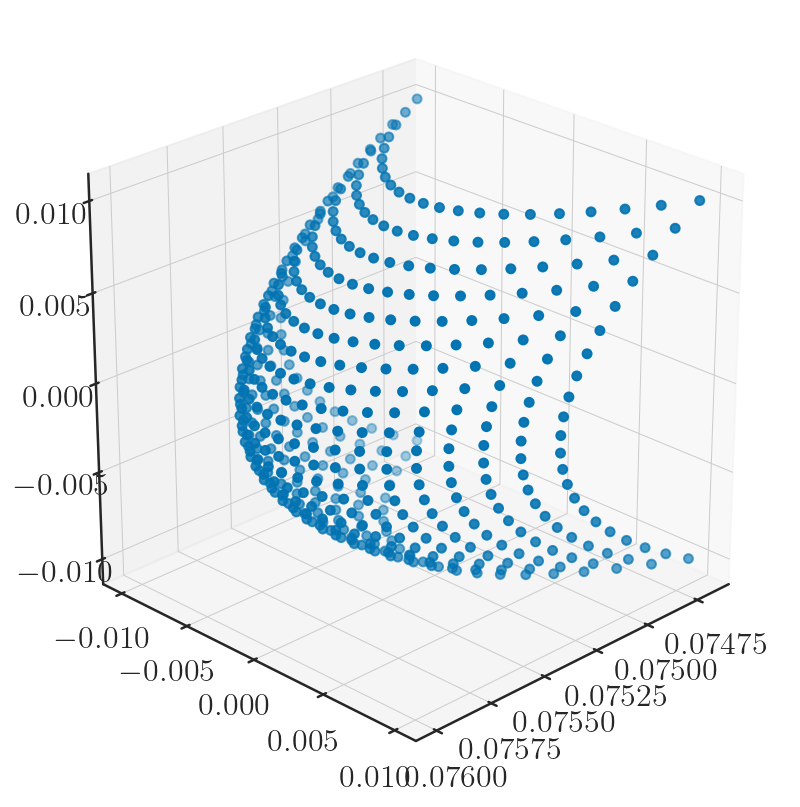

In [219]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.scatter(x, y, z)
ax.set_box_aspect([1, 1, 1])
#ax = set_axes_equal(ax)
ax.view_init(25, 45)